# Marmo: 12/31 dataset

In [1]:
# Import the rest
from __future__ import print_function
from __future__ import division

import sys

# sys.path.insert(0, '/home/dbutts/Code/')
sys.path.insert(0, 'C:\\Users\\Jake\\Documents\\')
sys.path.insert(0, 'C:\\Users\\Jake\\Documents\\NDN3')

import NDN3.NDNutils as NDNutils
# which_gpu = NDNutils.assign_gpu()
#NDNutils.setup_no_gpu()


import os
import h5py
import numpy as np
import tensorflow as tf
import scipy.io as sio           # importing matlab data
import matplotlib.pyplot as plt  # plotting
%matplotlib inline
from copy import deepcopy

import time
import random
import NDN3.NDN as NDN
#import TNDN as TNDN
import NDN3.Utils.DanUtils as DU
import NDN3.Utils.NDNplot as NDNplot
output_dir = 'C:\\Users\\Jake\\Dropbox\\Projects\\NDN\\output_dir'
# output_dir = '/Users/dbutts/Code/PyPlay/tensorboard'
print(sys.version)
import sys
print(sys.path)
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(1)

print(output_dir)

3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]
['C:\\Users\\Jake\\Documents\\NDN3', 'C:\\Users\\Jake\\Documents\\', 'C:\\Users\\Jake\\.conda\\envs\\NDN\\python36.zip', 'C:\\Users\\Jake\\.conda\\envs\\NDN\\DLLs', 'C:\\Users\\Jake\\.conda\\envs\\NDN\\lib', 'C:\\Users\\Jake\\.conda\\envs\\NDN', '', 'C:\\Users\\Jake\\.conda\\envs\\NDN\\lib\\site-packages', 'C:\\Users\\Jake\\.conda\\envs\\NDN\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Jake\\.ipython']
C:\Users\Jake\Dropbox\Projects\NDN\output_dir


In [2]:
# Load Data
dirname = "C:\\Users\\Jake\\Dropbox\\Projects\\FreeViewing\\Data\\"
includeSaccades=True

matdat=sio.loadmat(dirname + 'L20191231_Gabor.mat')
frameTimes1 = matdat['frameTimes'].copy()
stim1 = matdat['stim'].copy()
Robs1 = matdat['Robs'].copy()
valdat1 = matdat['valdata'].copy()
labels1 = matdat['labels'].copy()
if includeSaccades:
    valid1 = np.intersect1d(np.where(valdat1[:,0] == 1)[0], np.where(labels1[:,0] == 1)[0])
else:
    valid1 = np.intersect1d(np.where(valdat1[:,0] == 1)[0], np.where(np.logical_or(labels1[:,0]==2,labels1[:,0]==1))[0])
    
slist1 = matdat['slist'].astype(int)
dt = matdat['dt'][0][0]
NY = matdat['NX'][0][0].astype(int)
NP = stim1.shape[1]
ets1 = matdat['eyeAtFrame']
NX = (NP//NY).astype(int)
NT1,NCfull = Robs1.shape

matdat = sio.loadmat(dirname + 'L20191231_Grating.mat')
frameTimes2 = matdat['frameTimes'].copy()
stim2 = matdat['stim'].copy()
Robs2 = matdat['Robs'].copy()
valdat2 = matdat['valdata'].copy()
labels2 = matdat['labels'].copy()
# valid2 = np.intersect1d(np.where(valdat2[:,0] == 1)[0], np.where(labels2[:,0] == 1)[0])
if includeSaccades:
    valid2 = np.intersect1d(np.where(valdat2[:,0] == 1)[0], np.where(labels2[:,0] == 1)[0])
else:
    valid2 = np.intersect1d(np.where(valdat2[:,0] == 1)[0], np.where(np.logical_or(labels2[:,0]==2,labels2[:,0]==1))[0])
    
slist2 = matdat['slist'].astype(int)
ets2 = matdat['eyeAtFrame']
NT2 = Robs2.shape[0]
print(NT1, NT2, NCfull,'|', NX, NY)

matdat = sio.loadmat(dirname + 'L20191231_FixRsvpStim.mat')
frameTimes3 = matdat['frameTimes'].copy()
# matdat = sio.loadmat(dirname + 'L20191231_BackImage.mat')
stim3 = matdat['stim'].copy()
Robs3 = matdat['Robs'].copy()
valdat3 = matdat['valdata'].copy()
labels3 = matdat['labels'].copy()
# valid3 = np.intersect1d(np.where(valdat3[:,0] == 1)[0], np.where(labels3[:,0] == 1)[0])
if includeSaccades:
    valid3 = np.intersect1d(np.where(valdat3[:,0] == 1)[0], np.where(labels3[:,0] == 1)[0])
else:
    valid3 = np.intersect1d(np.where(valdat3[:,0] == 1)[0], np.where(np.logical_or(labels3[:,0]==2,labels3[:,0]==1))[0])
    
slist3 = matdat['slist'].astype(int)
ets3 = matdat['eyeAtFrame']
NT3 = Robs3.shape[0]
print(NT1, NT2, NT3, '|', NCfull, '|', NX, NY)

96984 77294 61 | 40 40
96984 77294 5275 | 61 | 40 40


In [3]:
# Filter data assuming eye tracking is good within certain radius: still using 3.1 deg (although easy to update)
# Determine valid indices based on eye position
valid_eye_rad = 5.0  # degrees
pixPerDeg = 37.50476617061
# Radial eye position (in degrees)
er1s = np.divide(np.sqrt(np.add(np.square(ets1[:,0]-640), np.square(ets1[:,1]-360))), pixPerDeg)
er2s = np.divide(np.sqrt(np.add(np.square(ets2[:,0]-640), np.square(ets2[:,1]-360))), pixPerDeg)
er3s = np.divide(np.sqrt(np.add(np.square(ets3[:,0]-640), np.square(ets3[:,1]-360))), pixPerDeg)

# Selection of valid indices where eye tracker estimated to be valid
eyeval1 = np.intersect1d(valid1, np.where(er1s < valid_eye_rad)[0])
eyeval2 = np.intersect1d(valid2, np.where(er2s < valid_eye_rad)[0])
eyeval3 = np.intersect1d(valid3, np.where(er3s < valid_eye_rad)[0])

# Make train and test inds for each trial
Uinds1, Xinds1 = NDNutils.generate_xv_folds(len(eyeval1), num_blocks=2)
Uinds2, Xinds2 = NDNutils.generate_xv_folds(len(eyeval2), num_blocks=2)
Uinds3, Xinds3 = NDNutils.generate_xv_folds(len(eyeval3), num_blocks=2)

In [22]:
### Concatenate data: 3 conditions
spaceL = 60
Sspacer = np.zeros([spaceL, NP], dtype='float32')
Rspacer = np.zeros([spaceL, NCfull], dtype='float32')
Tspacer = np.zeros([spaceL, 1], dtype='float32')

frameTimesAll = np.concatenate((frameTimes1, Tspacer, frameTimes2, Tspacer, frameTimes3), axis=0)

RobsAll = np.concatenate( (Robs1, Rspacer, Robs2, Rspacer, Robs3), axis=0)
# Assemble valid data and translate Ui's and Xi's 
valdata = np.concatenate( (eyeval1, eyeval2+NT1+spaceL, eyeval3+NT1+NT2+2*spaceL), axis=0 )
Ui1, Xi1 = Uinds1.copy(), Xinds1.copy()
Ui2, Xi2 = Uinds2.copy()+len(eyeval1), Xinds2.copy()+len(eyeval1)
Ui3, Xi3 = Uinds3.copy()+len(eyeval1)+len(eyeval2), Xinds3.copy()+len(eyeval1)+len(eyeval2)
Ui = np.concatenate((Ui1, Ui2, Ui3), axis=0)
Xi = np.concatenate((Xi1, Xi2, Xi3), axis=0)

stim = np.concatenate( (stim1.copy(), Sspacer.copy(), stim2.copy(), Sspacer.copy(), stim3.copy()), axis=0)
stim_norm = np.std(stim[valdata,:], axis=0)
stim = np.divide( stim, stim_norm)

NTfull = stim.shape[0]
NT = valdata.shape[0]

# Process saccades -- just store sacc offsets as delta functions
sac_on, sac_off = np.zeros([NTfull,1], dtype='float32'), np.zeros([NTfull,1], dtype='float32')
for nn in range(slist1.shape[0]):
    sac_on[slist1[nn,0]-1] = 1.0
    sac_off[slist1[nn,1]-1] = 1.0
for nn in range(slist2.shape[0]):
    sac_on[slist2[nn,0]-1+NT1+spaceL] = 1.0
    sac_off[slist2[nn,1]-1+NT1+spaceL] = 1.0
for nn in range(slist3.shape[0]):
    sac_on[slist3[nn,0]-1+NT1+NT2+2*spaceL] = 1.0
    sac_off[slist3[nn,1]-1+NT1+NT2+2*spaceL] = 1.0
    
ex = np.concatenate( (ets1[:,0].copy(), Sspacer[:,0], ets2[:,0].copy(), Sspacer[:,0], ets3[:,0].copy()), axis=0)-640
ey = np.concatenate( (ets1[:,1].copy(), Sspacer[:,0], ets2[:,1].copy(), Sspacer[:,0], ets3[:,1].copy()), axis=0)-360
print("Data size: %d (%d valid)"%(NTfull, NT) )
print("Train: %6d (%5d+%5d+%5d)"%(len(Ui), len(Ui1), len(Ui2), len(Ui3)))
print("Test:  %6d (%5d+%5d+%5d)"%(len(Xi), len(Xi1), len(Xi2), len(Xi3)))

Data size: 179673 (102724 valid)
Train:  82180 (40474+38003+ 3703)
Test:   20544 (10118+ 9500+  926)


In [4]:
### Concatenate data: 2 conditions -- this is what I use for now
spaceL = 60
Sspacer = np.zeros([spaceL, NP], dtype='float32')
Rspacer = np.zeros([spaceL, NCfull], dtype='float32')
Tspacer = np.zeros([spaceL, 1], dtype='float32')
RobsAll = np.concatenate( (Robs1, Rspacer, Robs2), axis=0)
frameTimesAll = np.concatenate((frameTimes1, Tspacer, frameTimes2), axis=0)
# Assemble valid data and translate Ui's and Xi's 
valdata = np.concatenate( (eyeval1, eyeval2+NT1+spaceL), axis=0 )
Ui1, Xi1 = Uinds1.copy(), Xinds1.copy()
Ui2, Xi2 = Uinds2.copy()+len(eyeval1), Xinds2.copy()+len(eyeval1)
Ui = np.concatenate((Ui1, Ui2), axis=0)
Xi = np.concatenate((Xi1, Xi2), axis=0)

stim = np.concatenate( (stim1.copy(), Sspacer.copy(), stim2.copy()), axis=0)
stim_norm = np.std(stim[valdata,:], axis=0)
stim = np.divide( stim, stim_norm)

NTfull = stim.shape[0]
NT = valdata.shape[0]

# Process saccades -- just store sacc offsets as delta functions
sac_on, sac_off = np.zeros([NTfull,1], dtype='float32'), np.zeros([NTfull,1], dtype='float32')
for nn in range(slist1.shape[0]):
    sac_on[slist1[nn,0]-1] = 1.0
    sac_off[slist1[nn,1]-1] = 1.0
for nn in range(slist2.shape[0]):
    sac_on[slist2[nn,0]-1+NT1+spaceL] = 1.0
    sac_off[slist2[nn,1]-1+NT1+spaceL] = 1.0
    
ex = np.concatenate( (ets1[:,0].copy(), Sspacer[:,0], ets2[:,0].copy()), axis=0)-640
ey = np.concatenate( (ets1[:,1].copy(), Sspacer[:,0], ets2[:,1].copy()), axis=0)-360
print("Data size: %d (%d valid)"%(NTfull, NT) )
print("Train: %6d (%5d+%5d)"%(len(Ui), len(Ui1), len(Ui2)))
print("Test:  %6d (%5d+%5d)"%(len(Xi), len(Xi1), len(Xi2)))

Data size: 174338 (98095 valid)
Train:  78477 (40474+38003)
Test:   19618 (10118+ 9500)


In [17]:
matdat = sio.loadmat(dirname + 'Cstim3.mat')
stim = matdat['Cstim'].copy()
del(matdat)
print(stim.shape)

(174338, 1600)


In [18]:
# Data adjustment
Nspks = np.sum(RobsAll[valdata,:],axis=0)
valcell = np.where(Nspks > 500)[0]  # arbitrary cutoff at this point...
NC = len(valcell)
Robs = RobsAll[:,valcell]
print( "%d out of %d cells selected"%(NC, RobsAll.shape[1]) )

58 out of 61 cells selected


In [19]:
adam_params = NDN.NDN.optimizer_defaults(opt_params={'use_gpu': True}, learning_alg='adam')

early_stopping = 100

adam_params['batch_size'] = NT // 100
adam_params['display'] = 30
adam_params['epochs_training'] = early_stopping * 100
adam_params['run_diagnostics'] = False

adam_params['epsilon'] = 1e-8
adam_params['early_stop'] = early_stopping
adam_params['early_stop_mode'] = 1
#adam_params['data_pipe_type'] = 'iterator'
adam_params['data_pipe_type'] = 'data_as_var'
adam_params['learning_rate'] = 1e-3
#adam_params['epochs_summary'] = 5
for d in adam_params:
    print("%20s:\t %s" %(d, adam_params[d]))

lbfgs_params = NDN.NDN.optimizer_defaults(opt_params={'use_gpu': True, 'display': True}, learning_alg='lbfgs')
lbfgs_params['maxiter'] = 1000
print('\nLBFGS:')
for d in lbfgs_params:
    print("%20s:\t %s" %(d, lbfgs_params[d]))

             use_gpu:	 True
             display:	 30
      data_pipe_type:	 data_as_var
   poisson_unit_norm:	 None
         epochs_ckpt:	 None
       learning_rate:	 0.001
          batch_size:	 980
     epochs_training:	 10000
     early_stop_mode:	 1
      epochs_summary:	 None
          early_stop:	 100
               beta1:	 0.9
               beta2:	 0.999
             epsilon:	 1e-08
     run_diagnostics:	 False

LBFGS:
             use_gpu:	 True
             display:	 True
      data_pipe_type:	 data_as_var
   poisson_unit_norm:	 None
         epochs_ckpt:	 None
             maxiter:	 1000
            func_tol:	 2.220446049250313e-09
            grad_tol:	 1e-05
                 eps:	 1e-08
          batch_size:	 None


# Model fitting -- stim alone

In [20]:
num_lags = 10
tmp = NDNutils.create_time_embedding( stim, [num_lags, NX, NX], tent_spacing=1 )
Xstim = deepcopy(tmp[valdata,:])

In [21]:
# Shift responses to take out first lag (just why bother with it)
Robs = NDNutils.shift_mat_zpad(RobsAll[:,valcell], 0, dim=0)
# STAs
stas = np.reshape(np.matmul(np.transpose(Xstim),Robs[valdata,:]), [NP,num_lags, NC])/len(valdata)
np.mean(np.max(abs(stas), axis=0))

0.00988830313531784

In [ ]:
DU.subplot_setup(6,10)
for cc in range(NC):
    ax = plt.subplot(6,10,cc+1)
    plt.plot(np.transpose(stas[:,:,cc]))
    #ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.title('cell '+str(cc))
plt.show()

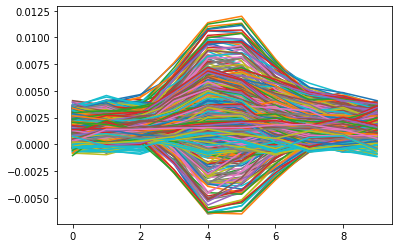

In [22]:
plt.plot(np.transpose(stas[:,:,52]))
plt.show()

In [ ]:
DU.subplot_setup(6,10)
for cc in range(NC):
    ax = plt.subplot(6,10,cc+1)
    #plt.plot(np.transpose(stas[:,:,cc]))
    bestlag = np.argmax(np.max(abs(stas[:,:,cc]),axis=0))
    plt.imshow(np.reshape(stas[:,bestlag,cc], [NX, NY]), cmap='gray')  #RdBu_r 
               #vmin=-np.max(abs(stas[:,:,cc])), vmax=np.max(abs(stas[:,:,cc])))
    plt.title(str(bestlag)+' cell '+str(cc),)
plt.show()

In [23]:
sio.savemat(dirname + "Cstim3_raw_output.mat", dict([('frameTime',frameTimesAll), ('valdata', valdata), ('Robs', Robs), ('sac_on', sac_on), ('sac_off', sac_off), ('stas', stas)]))
# sio.savemat(dirname + "Cstim3_raw_output.mat", dict([ ('LLs0', LLsX), ('predrate', predrate), ('valdata', valdata), ('Robs', Robs), ('sac_on', sac_on), ('sac_off', sac_off)]))


### WOW!!!

### Shared NIM 

In [24]:
Treg = 0.001
Xreg = 0.01
L1reg = 1e-6

num_tkerns = 2
num_subs = 16
snim_par = NDNutils.ffnetwork_params( 
    input_dims=[1,NY,NX, num_lags], layer_sizes=[num_tkerns, num_subs, NC], 
    layer_types=['conv', 'normal', 'normal'], conv_filter_widths=[1], ei_layers=[None, 2],
    normalization=[1,1,0], act_funcs=['lin', 'relu', 'softplus'],
    reg_list={'d2t':[Treg], 'd2x':[None, Xreg], 'l1':[None, L1reg]})

snim20 = NDN.NDN( snim_par, noise_dist='poisson' )
#snim0.networks[0].layers[0].weights = tkern0.copy() 
snim20.networks[0].layers[0].weights = np.zeros([num_lags, num_tkerns], dtype='float32')
snim20.networks[0].layers[0].weights[2,0] = 1.0
snim20.networks[0].layers[0].weights[3:5,1] = 1/np.sqrt(2)
v2f = snim20.fit_variables(layers_to_skip=[0], fit_biases=True)
_ = snim20.train(input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi, 
                fit_variables=v2f, learning_alg='adam', opt_params=adam_params)
LLu = snim20.eval_models(input_data=Xstim, output_data=Robs[valdata,:],
                        data_indxs=Ui, nulladjusted=False)
LLx = snim20.eval_models(input_data=Xstim, output_data=Robs[valdata,:],
                        data_indxs=Xi, nulladjusted=False)
print(np.mean(LLu), np.mean(LLx))

Input dimensions: [1, 40, 40, 10]
0: conv (lin):  	[E2/I0] N  	filter width = 1
1: normal (relu):  	[E14/I2] N
2: normal (softplus):  	[E58/I0] +
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 0000:  avg train cost =     7.5524,  avg test cost =     7.6207,  reg penalty =     0.0548
Epoch 0029:  avg train cost =     3.4162,  avg test cost =     3.4412,  reg penalty =     0.0082
Epoch 0059:  avg train cost =     3.3773,  avg test cost =     3.4118,  reg penalty =     0.0075
Epoch 0089:  avg train cost =     3.3689,  avg test cost =     3.4071,  reg penalty =     0.0078
Epoch 0119:  avg train cost =     3.3639,  avg test cost =     3.4027,  reg penalty =     0.0080
Epoch 0149:  avg train cost =     3.3607,  avg test cost =     3.4016,  reg penalty =     0.0082
Epoch 0179:  avg train cost =     3.3589,  avg test cost =     3.4022,  reg penalty =     0.0084
Epoch 0209:  avg train cost =     3.3583,  avg test cos

In [25]:
# Turning up regularization after initial fits established
snim21 = snim20.copy_model()
snim21.set_regularization('d2x',0.1, layer_target=1)
snim21.set_regularization('local',0.5, layer_target=1)
snim21.set_regularization('l1',0.002, layer_target=1)
_ = snim21.train(input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi, 
                fit_variables=v2f, learning_alg='adam', opt_params=adam_params)
LLu = snim21.eval_models(input_data=Xstim, output_data=Robs[valdata,:],
                        data_indxs=Ui, nulladjusted=False)
LLx = snim21.eval_models(input_data=Xstim, output_data=Robs[valdata,:],
                        data_indxs=Xi, nulladjusted=False)
print(np.mean(LLu), np.mean(LLx))

Epoch 0000:  avg train cost =     3.3699,  avg test cost =     3.4010,  reg penalty =     0.1041
Epoch 0029:  avg train cost =     3.3441,  avg test cost =     3.3422,  reg penalty =     0.0470
Epoch 0059:  avg train cost =     3.3417,  avg test cost =     3.3364,  reg penalty =     0.0442
Epoch 0089:  avg train cost =     3.3389,  avg test cost =     3.3322,  reg penalty =     0.0430
Epoch 0119:  avg train cost =     3.3379,  avg test cost =     3.3299,  reg penalty =     0.0420
Epoch 0149:  avg train cost =     3.3369,  avg test cost =     3.3284,  reg penalty =     0.0411
Epoch 0179:  avg train cost =     3.3367,  avg test cost =     3.3290,  reg penalty =     0.0405
Epoch 0209:  avg train cost =     3.3369,  avg test cost =     3.3285,  reg penalty =     0.0401
Epoch 0239:  avg train cost =     3.3362,  avg test cost =     3.3282,  reg penalty =     0.0398
Epoch 0269:  avg train cost =     3.3358,  avg test cost =     3.3269,  reg penalty =     0.0395
Epoch 0299:  avg train cost = 

In [26]:
# Turning up a little more
snim22 = snim21.copy_model()
snim22.set_regularization('d2x',0.2, layer_target=1)
snim22.set_regularization('local',0.8, layer_target=1)
snim22.set_regularization('l1',0.02, layer_target=1)
_ = snim22.train(input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi, 
                fit_variables=v2f, learning_alg='adam', opt_params=adam_params)
LLu = snim22.eval_models(input_data=Xstim, output_data=Robs[valdata,:],
                        data_indxs=Ui, nulladjusted=False)
LLx = snim22.eval_models(input_data=Xstim, output_data=Robs[valdata,:],
                        data_indxs=Xi, nulladjusted=False)
print(np.mean(LLu), np.mean(LLx))

Epoch 0000:  avg train cost =     3.3612,  avg test cost =     3.3294,  reg penalty =     0.1391
Epoch 0029:  avg train cost =     3.3672,  avg test cost =     3.3134,  reg penalty =     0.0931
Epoch 0059:  avg train cost =     3.3678,  avg test cost =     3.3117,  reg penalty =     0.0880
Epoch 0089:  avg train cost =     3.3673,  avg test cost =     3.3111,  reg penalty =     0.0859
Epoch 0119:  avg train cost =     3.3672,  avg test cost =     3.3097,  reg penalty =     0.0847
Epoch 0149:  avg train cost =     3.3669,  avg test cost =     3.3086,  reg penalty =     0.0839
Epoch 0179:  avg train cost =     3.3667,  avg test cost =     3.3087,  reg penalty =     0.0834
Epoch 0209:  avg train cost =     3.3662,  avg test cost =     3.3081,  reg penalty =     0.0834
Epoch 0239:  avg train cost =     3.3649,  avg test cost =     3.3066,  reg penalty =     0.0833
Epoch 0269:  avg train cost =     3.3627,  avg test cost =     3.3047,  reg penalty =     0.0831
Epoch 0299:  avg train cost = 

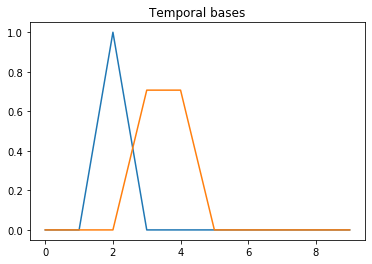

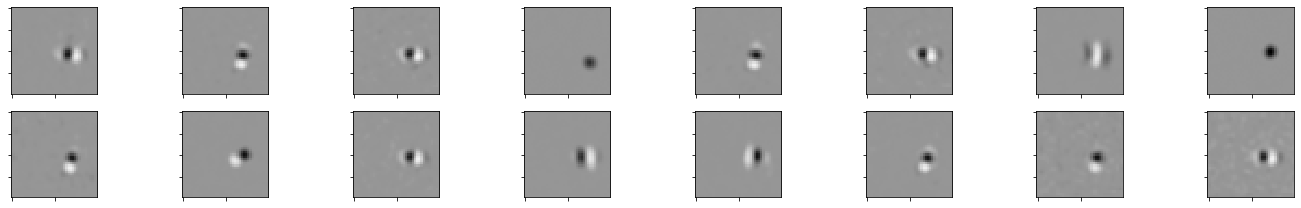

In [27]:
DU.plot_filters(snim22)

### Maybe a little too regularizad, but get the idea. Also need to handle inhibition a little differently....

In [28]:
# now with space determined, see what happens fitting temporal kernels more...
Treg = 0.001
snim22t = snim22.copy_model()
snim22t.set_regularization('d2t',0.2, layer_target=0)

Tv2f = snim22t.fit_variables(fit_biases=True)
_ = snim22t.train(input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi, 
                fit_variables=Tv2f, learning_alg='adam', opt_params=adam_params)
LLu = snim22t.eval_models(input_data=Xstim, output_data=Robs[valdata,:],
                        data_indxs=Ui, nulladjusted=False)
LLx = snim22t.eval_models(input_data=Xstim, output_data=Robs[valdata,:],
                        data_indxs=Xi, nulladjusted=False)
print(np.mean(LLu), np.mean(LLx))

Epoch 0000:  avg train cost =     3.3538,  avg test cost =     3.3036,  reg penalty =     0.1182
Epoch 0029:  avg train cost =     3.3264,  avg test cost =     3.2807,  reg penalty =     0.0933
Epoch 0059:  avg train cost =     3.3258,  avg test cost =     3.2823,  reg penalty =     0.0916
Epoch 0089:  avg train cost =     3.3253,  avg test cost =     3.2821,  reg penalty =     0.0904
Epoch 0119:  avg train cost =     3.3245,  avg test cost =     3.2839,  reg penalty =     0.0900

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 133,  end cost: 195.745428
     ---> best epoch: 86,  best cost: 195.558141

3.3242133 3.2855146


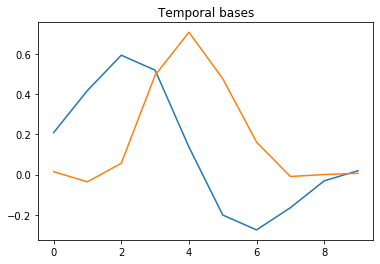

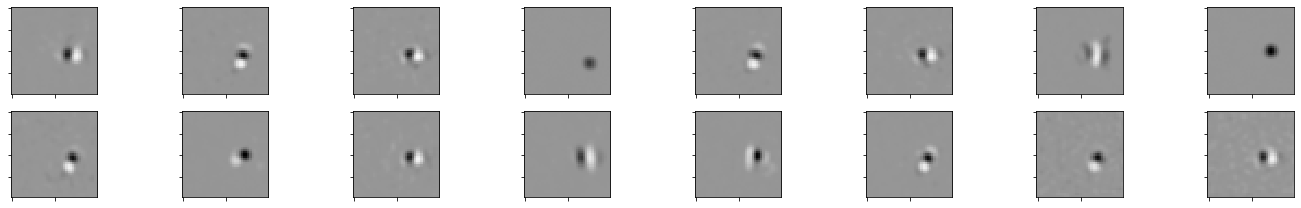

In [29]:
DU.plot_filters(snim22t)

In [30]:
# Check how well individual models doing (relative to null)
LLsX = np.zeros([2,NC])
LLsX[0,:] = snim22t.eval_models(
    input_data=Xstim, output_data=Robs[valdata,:],data_indxs=Xi1, nulladjusted=False)
LLsX[1,:] = snim22t.eval_models(
    input_data=Xstim, output_data=Robs[valdata,:],data_indxs=Xi2, nulladjusted=False)
print(np.mean(LLsX,axis=1))
LLsX[0,:] = snim22t.eval_models(
    input_data=Xstim, output_data=Robs[valdata,:],data_indxs=Xi1, nulladjusted=True)
LLsX[1,:] = snim22t.eval_models(
    input_data=Xstim, output_data=Robs[valdata,:],data_indxs=Xi2, nulladjusted=True)
print(np.mean(LLsX,axis=1))

[3.87701727 2.64896715]
[-0.50732462  1.2766775 ]


In [31]:
LLsX[1,:]

array([ 1.47740698,  5.5940547 ,  1.37094772,  2.76339459, -0.16159013,
        0.58621961,  0.31042424,  0.70701271,  0.15728918,  0.93265861,
        2.17644572,  1.67913532,  1.93865287,  1.68511605,  1.66757751,
        1.8000592 , -0.12240499,  2.00705981,  2.41047525,  2.11515856,
        1.03427029,  1.01289356,  1.95434904,  1.55839646,  1.0378902 ,
        0.96355414,  1.4536339 ,  1.5476917 ,  1.23577011,  1.46789002,
        1.04816639,  2.09657669,  1.09927654,  0.01205523,  0.40903664,
        1.11275005,  0.19935873, -0.08562438, -0.48894837,  1.56768703,
        1.21211386,  1.45418131,  0.92202252,  1.88576365,  1.3739475 ,
        0.01028062,  2.47720408,  1.48855388,  1.74657869,  0.62441444,
        2.72513151,  1.16246438,  0.32949841,  1.72409511,  0.99097025,
        0.79680878,  0.87244785,  0.91905063])

In [32]:
# Export model for matlab
snim22t.save_model(dirname + "snim22t_1231")

snim22t.matlab_export(dirname + "snim22texport_1231")


predrate = snim22t.generate_prediction(input_data=Xstim)

sio.savemat(dirname + "snim22t_output.mat", dict([ ('LLs0', LLsX), ('predrate', predrate), ('valdata', valdata), ('Robs', Robs), ('sac_on', sac_on), ('sac_off', sac_off)]))



Model pickled to C:\Users\Jake\Dropbox\Projects\FreeViewing\Data\snim22t_1231


In [47]:
staModel = np.reshape(np.matmul(np.transpose(Xstim),predrate[valdata,:]), [NP,num_lags, NC])/len(valdata)

In [50]:
DU.subplot_setup(6,10)
for cc in range(NC):
    ax = plt.subplot(6,10,cc+1)
    plt.plot(np.transpose(staModel[:,:,cc]))
    #ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.title('cell '+str(cc))
plt.show()

In [54]:
sio.savemat(dirname + "modelSTAs.mat", dict([('staModel', staModel), ("predrate", predrate), ("valdata", valdata), ('frameTimes', frameTimesAll)]))

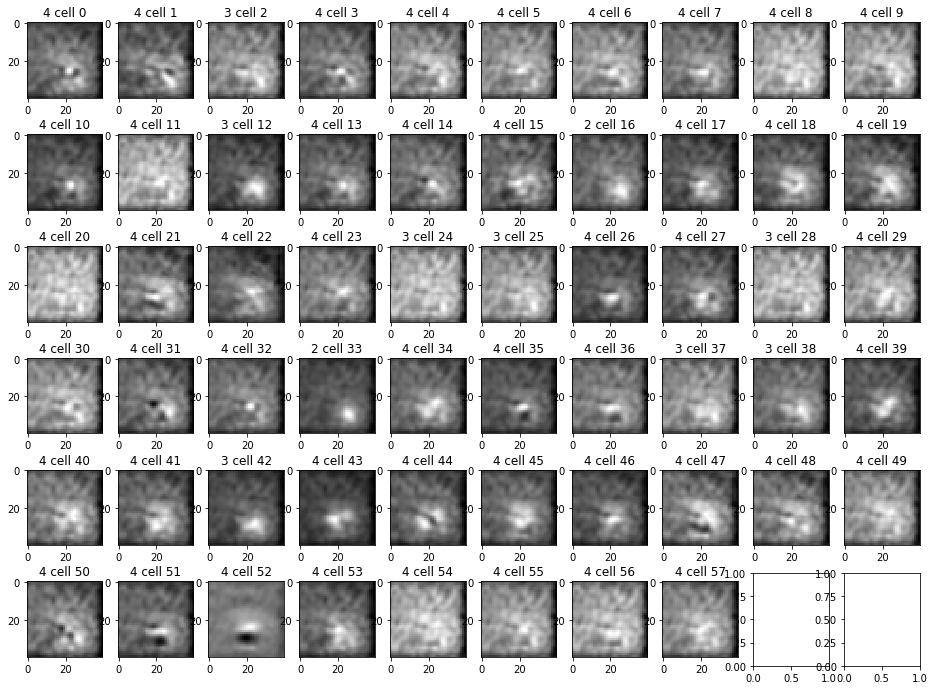

In [53]:
DU.subplot_setup(6,10)
for cc in range(NC):
    ax = plt.subplot(6,10,cc+1)
    #plt.plot(np.transpose(stas[:,:,cc]))
    bestlag = np.argmax(np.max(abs(staModel[:,:,cc]),axis=0))
    plt.imshow(np.reshape(staModel[:,bestlag,cc], [NX, NY]), cmap='gray')  #RdBu_r 
               #vmin=-np.max(abs(stas[:,:,cc])), vmax=np.max(abs(stas[:,:,cc])))
    plt.title(str(bestlag)+' cell '+str(cc),)
plt.show()

In [33]:
Treg = 0.01
# Final values, after initially starting weaker
Xreg = 0.1
L1reg = 0.1
LOCreg = 0.2

In [34]:
## Try different temporal kernels between excitation and suppression... (and for now just one each...)
# but actually they wanted to be the same....
num_tkerns = 2
num_Esubs, num_Isubs = 16,4

Esubs_par = NDNutils.ffnetwork_params( 
    input_dims=[1,NY,NX, num_lags], layer_sizes=[num_tkerns, num_Esubs], 
    layer_types=['conv', 'normal'], conv_filter_widths=[1], ei_layers=[None, 0],
    normalization=[1,1], act_funcs=['lin', 'relu'],
    reg_list={'d2t':[Treg], 'd2x':[None, Xreg], 'l1':[None, 1e-6], 'local':[None,1e-5]})
Isubs_par = NDNutils.ffnetwork_params( 
    input_dims=[1,NY,NX, num_lags], layer_sizes=[num_tkerns, num_Isubs], 
    layer_types=['conv', 'normal'], conv_filter_widths=[1], ei_layers=[None, num_Isubs],
    normalization=[1,1], act_funcs=['lin', 'relu'],
    reg_list={'d2t':[Treg], 'd2x':[None, Xreg], 'l1':[None, 1e-6], 'local':[None,1e-5]})
comb_par = NDNutils.ffnetwork_params( 
    xstim_n=None, ffnet_n=[0,1], layer_sizes=[NC], layer_types=['normal'], act_funcs=['softplus'],
    reg_list={'max':[None]})
comb_par['pos_constraints'] = True

snimEI0 = NDN.NDN( [Esubs_par, Isubs_par, comb_par], ffnet_out=2, noise_dist='poisson' )
#snim0.networks[0].layers[0].weights = tkern0.copy() 
snimEI0.networks[0].layers[0].weights = np.zeros([num_lags, num_tkerns], dtype='float32')
snimEI0.networks[0].layers[0].weights[2:4,0] = 1.0/np.sqrt(2)
snimEI0.networks[1].layers[0].weights = np.zeros([num_lags, num_tkerns], dtype='float32')
snimEI0.networks[1].layers[0].weights[2:4,0] = 1.0/np.sqrt(2)
v2f = snimEI0.fit_variables(layers_to_skip=[[0],[0]], fit_biases=True)

# First train without much reg, and then turn on
_ = snimEI0.train(input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi, fit_variables=v2f, 
                  learning_alg='adam', opt_params=adam_params )


Input dimensions: [1, 40, 40, 10]
0: conv (lin):  	[E2/I0] N  	filter width = 1
1: normal (relu):  	[E16/I0] N
Input dimensions: [1, 40, 40, 10]
0: conv (lin):  	[E2/I0] N  	filter width = 1
1: normal (relu):  	[E0/I4] N
0: normal (softplus):  	[E58/I0] 
Epoch 0000:  avg train cost =     6.7446,  avg test cost =     6.7533,  reg penalty =     0.1066
Epoch 0029:  avg train cost =     3.4514,  avg test cost =     3.4641,  reg penalty =     0.0193
Epoch 0059:  avg train cost =     3.4296,  avg test cost =     3.4447,  reg penalty =     0.0158
Epoch 0089:  avg train cost =     3.4238,  avg test cost =     3.4345,  reg penalty =     0.0098
Epoch 0119:  avg train cost =     3.4193,  avg test cost =     3.4360,  reg penalty =     0.0080
Epoch 0149:  avg train cost =     3.4162,  avg test cost =     3.4369,  reg penalty =     0.0074
Epoch 0179:  avg train cost =     3.4138,  avg test cost =     3.4393,  reg penalty =     0.0072

*** early stop criteria met...stopping train now...
     ---> num

In [35]:
snimEI1 = snimEI0.copy_model()
# now fit temporal kernels for real as well
snimEI2 = snimEI1.copy_model()
v2f = snimEI2.fit_variables(fit_biases=True)
L1reg = 0.01
LOCreg = 0.1
snimEI1.set_regularization('d2x', Xreg, ffnet_target=0, layer_target=1)
snimEI1.set_regularization('local', LOCreg,  ffnet_target=0, layer_target=1)
snimEI1.set_regularization('l1', L1reg,  ffnet_target=0, layer_target=1)
snimEI1.set_regularization('d2x', Xreg, ffnet_target=1, layer_target=1)
snimEI1.set_regularization('local', LOCreg*2,  ffnet_target=1, layer_target=1)
snimEI1.set_regularization('l1', L1reg*2,  ffnet_target=1, layer_target=1)

_ = snimEI1.train(input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi, fit_variables=v2f,
                  learning_alg='adam', opt_params=adam_params )

LLu = snimEI1.eval_models(input_data=Xstim, output_data=Robs[valdata,:],
                        data_indxs=Ui, nulladjusted=False)
LLx = snimEI1.eval_models(input_data=Xstim, output_data=Robs[valdata,:],
                        data_indxs=Xi, nulladjusted=False)
print(np.mean(LLu), np.mean(LLx))

Epoch 0000:  avg train cost =     4.8445,  avg test cost =     5.8020,  reg penalty =     0.2456
Epoch 0029:  avg train cost =     3.3537,  avg test cost =     3.4001,  reg penalty =     0.1559
Epoch 0059:  avg train cost =     3.3347,  avg test cost =     3.3443,  reg penalty =     0.1184
Epoch 0089:  avg train cost =     3.3279,  avg test cost =     3.3205,  reg penalty =     0.1033
Epoch 0119:  avg train cost =     3.3230,  avg test cost =     3.3080,  reg penalty =     0.0946
Epoch 0149:  avg train cost =     3.3222,  avg test cost =     3.3041,  reg penalty =     0.0893
Epoch 0179:  avg train cost =     3.3143,  avg test cost =     3.2959,  reg penalty =     0.0855
Epoch 0209:  avg train cost =     3.3117,  avg test cost =     3.2899,  reg penalty =     0.0835
Epoch 0239:  avg train cost =     3.3099,  avg test cost =     3.2872,  reg penalty =     0.0819
Epoch 0269:  avg train cost =     3.3095,  avg test cost =     3.2863,  reg penalty =     0.0809
Epoch 0299:  avg train cost = 

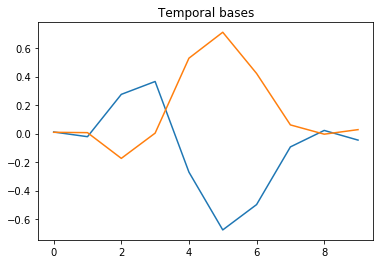

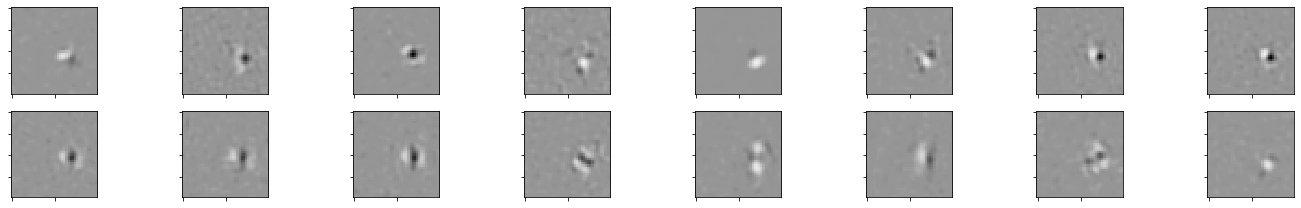

In [40]:
DU.plot_filters(snimEI1)

In [37]:
# Export model for matlab

snimEI1.save_model(dirname + "snimEI1_1231")

snimEI1.matlab_export(dirname + "snimEI1export_1231")


predrate = snimEI1.generate_prediction(input_data=tmp)

sio.savemat(dirname + "snimEI1_output.mat", dict([ ('LLs0', LLsX), ('predrate', predrate), ('valdata', valdata), ('Robs', Robs), ('sac_on', sac_on), ('sac_off', sac_off)]))

Model pickled to C:\Users\Jake\Dropbox\Projects\FreeViewing\Data\snimEI1_1231


The temporal kernels did not end up being any different here, and EI did not seem to help, so skipping this last part.

## Saccade kernels

In [41]:
saconsets, sacoffsets = np.zeros([NTfull,1], dtype='float32'), np.zeros([NTfull,1], dtype='float32')
num_saclags = 40
num_pre = 10
saconsets[:(NTfull-num_pre)]=sac_on[num_pre:]
sacoffsets[:(NTfull-num_pre)]=sac_off[num_pre:]

Xsac1 = NDNutils.create_time_embedding(saconsets, [num_saclags, 1, 1], tent_spacing=1)
Xsac2 = NDNutils.create_time_embedding(sacoffsets, [num_saclags, 1, 1], tent_spacing=1)
TSreg = 0.001

In [42]:
# intialize with previous stim-only model
prev_mod = snim22t.copy_model()

# Read off end regularization of previous model
Treg = prev_mod.networks[0].layers[0].reg.vals['d2t']
Xreg = prev_mod.networks[0].layers[1].reg.vals['d2x']
LOCreg = prev_mod.networks[0].layers[1].reg.vals['local']
L1reg = prev_mod.networks[0].layers[1].reg.vals['l1']



num_tkerns = 2
num_subs=16



In [ ]:
prev_mod.networks[0].layers[1].reg.vals['d2x']

### Additive saccade kernels (for onset and offset)

In [43]:
num_tkerns = 2
num_subs = 16
tnim1_par = NDNutils.ffnetwork_params( 
    input_dims=[1,NY,NX, num_lags], layer_sizes=[num_tkerns, num_subs, NC], 
    layer_types=['conv', 'normal', 'normal'], conv_filter_widths=[1], ei_layers=[None, 2],
    normalization=[1,1,0], act_funcs=['lin', 'relu', 'lin'], # note lin as last stage
    reg_list={'d2t':[Treg], 'd2x':[None, Xreg], 'l1':[None, L1reg], 'local':[None,LOCreg]})
sac1_par = NDNutils.ffnetwork_params( 
    input_dims=[1,1,1, num_saclags], xstim_n=[1],
    layer_sizes=[1, NC], layer_types=['normal', 'normal'], normalization=[1,0], 
    act_funcs=['relu', 'lin'], reg_list={'d2t':[TSreg]})  # make rectified, but don't have to
sac2_par = NDNutils.ffnetwork_params( 
    input_dims=[1,1,1, num_saclags], xstim_n=[2],
    layer_sizes=[1, NC], layer_types=['normal', 'normal'], normalization=[1, 0], act_funcs=['relu', 'lin'],
    reg_list={'d2t':[TSreg]})
comb_par = NDNutils.ffnetwork_params( 
    xstim_n=None, ffnet_n=[0,1,2], layer_sizes=[NC], layer_types=['add'], act_funcs=['softplus'])

sacnim0 = NDN.NDN( [tnim1_par, sac1_par, sac2_par, comb_par], ffnet_out=3, noise_dist='poisson' )
sacnim0.networks[0].layers[0].weights = deepcopy(prev_mod.networks[0].layers[0].weights)
sacnim0.networks[0].layers[1].weights = deepcopy(prev_mod.networks[0].layers[1].weights)
sacnim0.networks[0].layers[1].biases = deepcopy(prev_mod.networks[0].layers[1].biases)
sacnim0.networks[0].layers[2].weights = deepcopy(prev_mod.networks[0].layers[2].weights)

# initially just fit saccade kernels
v2f0 = sacnim0.fit_variables(layers_to_skip=[[0,1,2]], fit_biases=True)
v2f0[1][1]['biases']=False
v2f0[2][1]['biases']=False
v2f0[3][0]['weights']=False

# Then can fit everything but temporal kernels for stim
v2f = sacnim0.fit_variables(layers_to_skip=[[0]], fit_biases=True)
v2f[0][2]['biases']=False
v2f[1][1]['biases']=False
v2f[2][1]['biases']=False
v2f[3][0]['weights']=False

_ = sacnim0.train(
    input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], output_data=Robs[valdata,:], 
    train_indxs=Ui, test_indxs=Xi, fit_variables=v2f0, 
    learning_alg='adam', opt_params=adam_params)
#sacnim0.set_regularization('l1', 0.02, ffnet_target = 0, layer_target=1)
#_ = sacnim0.train(
#    input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], output_data=Robs[valdata,:], 
#    train_indxs=Ui, test_indxs=Xi, fit_variables=v2f, 
#    learning_alg='adam', opt_params=adam_params, output_dir=output_dir )

LL1u = sacnim0.eval_models(input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], 
                           output_data=Robs[valdata,:], data_indxs=Ui, nulladjusted=False)
LL1x = sacnim0.eval_models(input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], 
                           output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=False)
LL1n = sacnim0.eval_models(input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], 
                           output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=True)

print(np.mean(LL1u), np.mean(LL1x), np.mean(LL1n))

Input dimensions: [1, 40, 40, 10]
0: conv (lin):  	[E2/I0] N  	filter width = 1
1: normal (relu):  	[E14/I2] N
2: normal (lin):  	[E58/I0] +
Input dimensions: [1, 1, 1, 40]
0: normal (relu):  	[E1/I0] N
1: normal (lin):  	[E58/I0] 
Input dimensions: [1, 1, 1, 40]
0: normal (relu):  	[E1/I0] N
1: normal (lin):  	[E58/I0] 
0: add (softplus):  	[E58/I0] 
Epoch 0000:  avg train cost =     7.1184,  avg test cost =     7.0906,  reg penalty =     0.0896
Epoch 0029:  avg train cost =     3.3558,  avg test cost =     3.3010,  reg penalty =     0.0894
Epoch 0059:  avg train cost =     3.3533,  avg test cost =     3.3000,  reg penalty =     0.0894
Epoch 0089:  avg train cost =     3.3525,  avg test cost =     3.2990,  reg penalty =     0.0894
Epoch 0119:  avg train cost =     3.3516,  avg test cost =     3.2986,  reg penalty =     0.0894
Epoch 0149:  avg train cost =     3.3509,  avg test cost =     3.2979,  reg penalty =     0.0894
Epoch 0179:  avg train cost =     3.3501,  avg test cost =     3

In [45]:
# Export model for matlab

sacnim0.save_model(dirname + "sacnim0_1231")

sacnim0.matlab_export(dirname + "sacnim0export_1231")

predrate = sacnim0.generate_prediction(input_data=[tmp, Xsac1, Xsac2])

sio.savemat(dirname + "sacnim0_output.mat", dict([ ('LLs0', LL1x), ('predrate', predrate), ('valdata', valdata), ('Robs', Robs), ('sac_on', sac_on), ('sac_off', sac_off)]))

Model pickled to C:\Users\Jake\Dropbox\Projects\FreeViewing\Data\sacnim0_1231


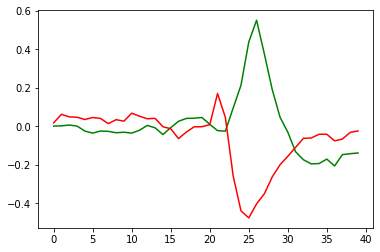

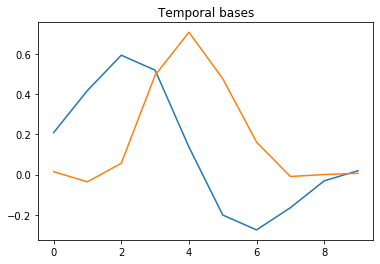

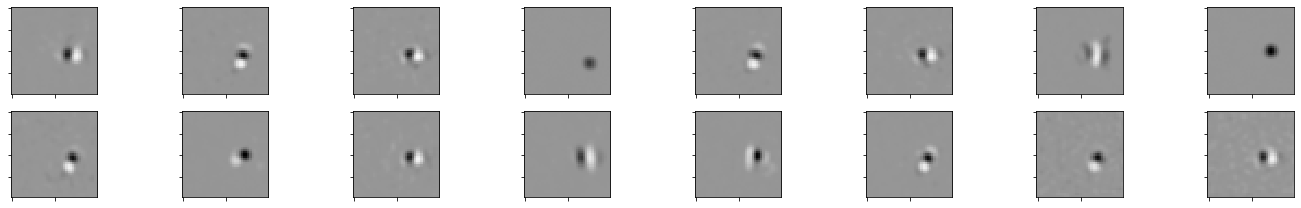

In [46]:
plt.plot(sacnim0.networks[1].layers[0].weights,'g')
plt.plot(sacnim0.networks[2].layers[0].weights,'r')
plt.show()
DU.plot_filters(sacnim0)

In [103]:
sacnim1 = sacnim0.copy_model()
#sacnim0.set_regularization('l1', 0.02, ffnet_target = 0, layer_target=1)
_ = sacnim1.train(
    input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], output_data=Robs[valdata,:], 
    train_indxs=Ui, test_indxs=Xi, fit_variables=v2f, 
    learning_alg='adam', opt_params=adam_params, output_dir=output_dir )
LL1u = sacnim1.eval_models(input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], 
                           output_data=Robs[valdata,:], data_indxs=Ui, nulladjusted=False)
LL1x = sacnim1.eval_models(input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], 
                           output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=False)
LL1n = sacnim1.eval_models(input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], 
                           output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=True)

print(np.mean(LL1u), np.mean(LL1x), np.mean(LL1n))

Epoch 0000:  avg train cost =     3.3110,  avg test cost =     3.2675,  reg penalty =     0.1271
Epoch 0029:  avg train cost =     3.2774,  avg test cost =     3.2490,  reg penalty =     0.1175
Epoch 0059:  avg train cost =     3.2711,  avg test cost =     3.2526,  reg penalty =     0.1157
Epoch 0089:  avg train cost =     3.2700,  avg test cost =     3.2589,  reg penalty =     0.1146

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 107,  end cost: 195.687311
     ---> best epoch: 21,  best cost: 195.201743

INFO:tensorflow:Restoring parameters from /home/dbutts/V1/pkls/output_dir0/bstmods/best_model
3.2783468 3.2474985 0.3604901


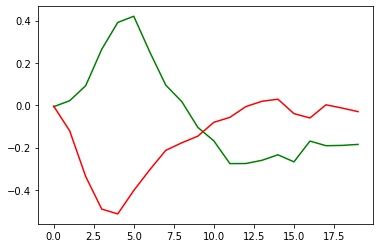

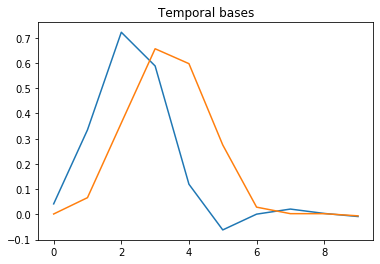

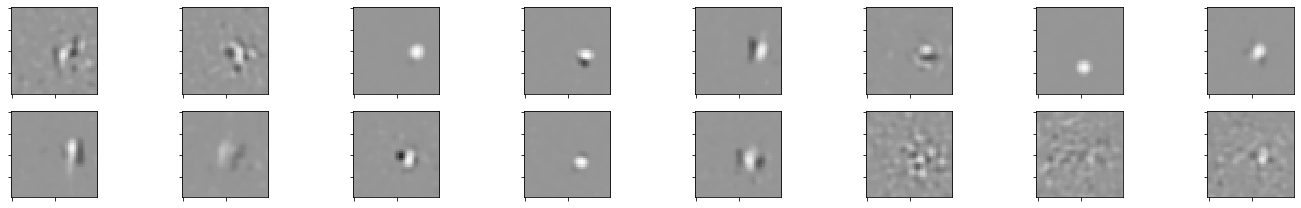

In [104]:
plt.plot(sacnim1.networks[1].layers[0].weights,'g')
plt.plot(sacnim1.networks[2].layers[0].weights,'r')
plt.show()
DU.plot_filters(sacnim1)

In [107]:
LLsac = sacnim1.eval_models(input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], 
                           output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=True)
print(LLsac)

[-0.0455923   0.66976446  0.2776679   0.4966012   0.15835246  0.02253384
  0.00191135  0.02802866 -0.04800771 -0.11244027  0.45883277  1.1003777
  0.25954616  0.33446902  0.34210342  0.22392859 -0.04738039  0.45668173
  0.35301664  0.61490077  1.0671499   0.56041455  0.62781525  0.86377907
  0.73743063  0.6044389   0.2631422   0.26081836  1.1742615   0.8920805
  0.07245398  0.06537569  0.10446603 -0.02949635  0.15202445  0.1248413
  0.09483004  0.06202284  0.15223663  0.4962443   0.43804687  0.63149804
  0.14322908  0.64907616  0.54790694  0.3909737   0.79424155  0.99960315
  0.3489175   0.12053581  0.2927828   0.5115932  -0.1564104   0.37852898
  0.6756665  -0.04598959  0.41503504 -0.11843708]


## Gain-related saccadic modulation

In [116]:
# shift backwards in time too (doesnt have to be causal!)
back_shifts = 2
num_saclags2 = 20+back_shifts
Xsac1b = NDNutils.create_time_embedding(
    NDNutils.shift_mat_zpad(sac_on,-back_shifts,dim=0), [num_saclags2, 1, 1], tent_spacing=1)
#Xsac1b = NDNutils.create_time_embedding(
#    sac_on_alt,, [num_saclags2, 1, 1], tent_spacing=1)
Xsac2b = NDNutils.create_time_embedding(
    NDNutils.shift_mat_zpad(sac_off,-back_shifts,dim=0), [num_saclags2, 1, 1], tent_spacing=1)
TSreg2 = 0.001

In [117]:
# GAIN FROM SAC ONSET, ADDITIVE FIX ONSET
num_Esubs = 14
num_Isubs = 2
mnim1_par = NDNutils.ffnetwork_params( 
    input_dims=[1,NY,NX, num_lags], layer_sizes=[num_tkerns, num_Esubs+num_Isubs, NC], 
    layer_types=['conv', 'normal', 'normal'], conv_filter_widths=[1], ei_layers=[None, num_Isubs],
    normalization=[1,1,0], act_funcs=['lin', 'relu', 'lin'],
    reg_list={'d2t':[Treg], 'd2x':[None, Xreg], 'l1':[None, L1reg/2], 'local':[None,LOCreg]})
sac1_par = NDNutils.ffnetwork_params( 
    input_dims=[1,1,1, num_saclags2], xstim_n=[1],
    layer_sizes=[1, NC], layer_types=['normal', 'normal'], normalization=[1,0], act_funcs=['lin', 'lin'],
    reg_list={'d2t':[TSreg2]})
stim_par = NDNutils.ffnetwork_params( 
    xstim_n=None, ffnet_n=[0,1],
    layer_sizes=[NC], layer_types=['mult'], normalization=[0], act_funcs=['lin'])
sac2_par = NDNutils.ffnetwork_params( 
    input_dims=[1,1,1, num_saclags2], xstim_n=[2],
    layer_sizes=[1, NC], layer_types=['normal', 'normal'], normalization=[1, 0], act_funcs=['lin', 'lin'],
    reg_list={'d2t':[TSreg2]})
comb_par = NDNutils.ffnetwork_params( 
    xstim_n=None, ffnet_n=[2,3], layer_sizes=[NC], layer_types=['add'], act_funcs=['softplus'])

gmodsac0 = NDN.NDN( [mnim1_par, sac1_par, stim_par, sac2_par, comb_par], ffnet_out=4, noise_dist='poisson' )
gmodsac0.networks[0].layers[0].weights = deepcopy(sacnim1.networks[0].layers[0].weights)
gmodsac0.networks[0].layers[1].weights = deepcopy(sacnim1.networks[0].layers[1].weights)
gmodsac0.networks[0].layers[1].biases = deepcopy(sacnim1.networks[0].layers[1].biases)
gmodsac0.networks[0].layers[2].weights = deepcopy(sacnim1.networks[0].layers[2].weights)

v2f0 = gmodsac0.fit_variables(layers_to_skip=[[0,1,2]], fit_biases=True)
v2f0[1][1]['biases']=False
v2f0[2][0]['biases']=False
v2f0[3][1]['biases']=False
v2f0[4][0]['weights']=False

v2f = gmodsac0.fit_variables(layers_to_skip=[[0]], fit_biases=True)
v2f[0][2]['biases']=False
v2f[1][1]['biases']=False
v2f[2][0]['biases']=False
v2f[3][1]['biases']=False
v2f[4][0]['weights']=False

# dont fit stim terms yet
_ = gmodsac0.train(
    input_data=[Xstim, Xsac1b[valdata,:], Xsac2b[valdata,:]], output_data=Robs[valdata,:], 
    train_indxs=Ui, test_indxs=Xi, fit_variables=v2f0, 
    learning_alg='adam', opt_params=adam_params, output_dir=output_dir )

# now fit stim terms too 
_ = gmodsac0.train(
    input_data=[Xstim, Xsac1b[valdata,:], Xsac2b[valdata,:]], output_data=Robs[valdata,:], 
    train_indxs=Ui, test_indxs=Xi, fit_variables=v2f, 
    learning_alg='adam', opt_params=adam_params, output_dir=output_dir )

LL1u = gmodsac0.eval_models(input_data=[Xstim, Xsac1b[valdata,:], Xsac2b[valdata,:]], 
                           output_data=Robs[valdata,:], data_indxs=Ui, nulladjusted=False)
LL1x = gmodsac0.eval_models(input_data=[Xstim, Xsac1b[valdata,:], Xsac2b[valdata,:]], 
                           output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=False)
LL1n = gmodsac0.eval_models(input_data=[Xstim, Xsac1b[valdata,:], Xsac2b[valdata,:]], 
                           output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=True)

print(np.mean(LL1u), np.mean(LL1x), np.mean(LL1n))

Input dimensions: [1, 40, 40, 10]
0: conv (lin):  	[E2/I0] N  	filter width = 1
1: normal (relu):  	[E14/I2] N
2: normal (lin):  	[E58/I0] +
Input dimensions: [1, 1, 1, 22]
0: normal (lin):  	[E1/I0] N
1: normal (lin):  	[E58/I0] 
0: mult (lin):  	[E58/I0] 
Input dimensions: [1, 1, 1, 22]
0: normal (lin):  	[E1/I0] N
1: normal (lin):  	[E58/I0] 
0: add (softplus):  	[E58/I0] 
Epoch 0000:  avg train cost =     6.9362,  avg test cost =     6.8964,  reg penalty =     0.0753
Epoch 0029:  avg train cost =     3.2945,  avg test cost =     3.2728,  reg penalty =     0.0753
Epoch 0059:  avg train cost =     3.2841,  avg test cost =     3.2591,  reg penalty =     0.0752
Epoch 0089:  avg train cost =     3.2832,  avg test cost =     3.2586,  reg penalty =     0.0752
Epoch 0119:  avg train cost =     3.2827,  avg test cost =     3.2581,  reg penalty =     0.0752
Epoch 0149:  avg train cost =     3.2823,  avg test cost =     3.2576,  reg penalty =     0.0752
Epoch 0179:  avg train cost =     3.282

Ugh -- looks like fitting stim after hurts.. will have to fix this...

In [115]:
LL1u = gmodsac0.eval_models(input_data=[Xstim, Xsac1b[valdata,:], Xsac2b[valdata,:]], 
                           output_data=Robs[valdata,:], data_indxs=Ui, nulladjusted=False)
LL1x = gmodsac0.eval_models(input_data=[Xstim, Xsac1b[valdata,:], Xsac2b[valdata,:]], 
                           output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=False)
LL1n = gmodsac0.eval_models(input_data=[Xstim, Xsac1b[valdata,:], Xsac2b[valdata,:]], 
                           output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=True)

print(np.mean(LL1u), np.mean(LL1x), np.mean(LL1n))

3.2779763 3.2549102 0.35307866


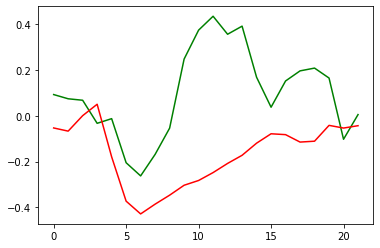

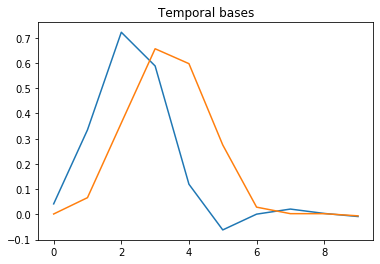

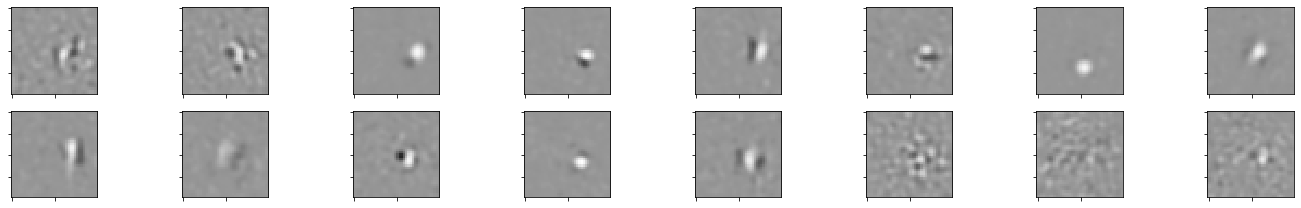

In [118]:
plt.plot(gmodsac0.networks[1].layers[0].weights,'g')
plt.plot(gmodsac0.networks[3].layers[0].weights,'r')
plt.show()
DU.plot_filters(gmodsac0)